Image feature extraction

In [299]:
import torch 
import torch.nn as nn
import torchvision.models as models

In [300]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size, train_CNN=False):
        super(EncoderCNN, self).__init__()
        self.train_CNN = False
        self.inception = models.inception_v3(pretrained=True, aux_logits=True)
        self.inception.fc = nn.Linear(self.inception.fc.in_features, embed_size) # Remap last linear layer to embed size
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, images):
        features = self.inception(images)
        return self.dropout(self.relu(features[0])) # [0] because aux_logits bug https://discuss.pytorch.org/t/inception-v3-is-not-working-very-well/38296/3

Sequence Model for Language Processing

In [301]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions):
        embeddings = self.dropout(self.embed(captions))
        embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs

Combining Image and Text Data

In [302]:
class CNNtoRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(CNNtoRNN, self).__init__()
        self.encoderCNN = EncoderCNN(embed_size)
        self.decoderRNN = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        features = self.encoderCNN(images)
        outputs = self.decoderRNN(features, captions)
        return outputs

    def caption_image(self, image, vocabulary, max_length=50):
        result_caption = []

        with torch.no_grad():
            x = self.encoderCNN(image).unsqueeze(0) # Sets image features from CNN as input to RNN
            states = None

            # Predicts each word of the caption
            for _ in range(max_length):
                hiddens, states = self.decoderRNN.lstm(x, states)
                output = self.decoderRNN.linear(hiddens.squeeze(0))
                predicted = output.argmax(0)
                result_caption.append(predicted.item())
                x = self.decoderRNN.embed(predicted).unsqueeze(0) # Takes predicted word and sets as input for next time step

                if vocabulary.itos[predicted.item()] == "<EOS>":
                    break

        return [vocabulary.itos[idx] for idx in result_caption]

Training the Network

In [303]:
import torch.optim as optim
import torchvision.transforms as transforms
from get_loader import get_loader
from utils import save_checkpoint, load_checkpoint
import lightning as L
from PIL import Image

class ImageCaptioner(L.LightningModule):
    def __init__(self, ic_model, dataset, criterion):
        super().__init__()
        self.CNNtoRNN = ic_model
        self.dataset = dataset
        self.criterion = criterion

        #Only train fc layer
        for name, param in self.CNNtoRNN.encoderCNN.inception.named_parameters():
            if "fc.weight" in name or "fc.bias" in name:
                param.requires_grad = True
            else:
                param.requires_grad = False

    def training_step(self, batch, batch_idx):
        imgs, captions = batch
        outputs = self.CNNtoRNN(imgs, captions[:-1]) # Don't send in last one because that what we want to predict
        loss = self.criterion(outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1)) # reshapes from (seq_len, N, voc_size) to seq_len and N being concatenated)
        self.log("Traning loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self, learning_rate = 1e-3):
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        return optimizer


In [304]:
transform = transforms.Compose(
    [
        transforms.Resize((356, 356)),
        transforms.RandomCrop((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # Suggested for pre-trained models https://pytorch.org/hub/pytorch_vision_inception_v3/
    ]
)

train_loader, dataset = get_loader(
    root_folder = "Flickr8k/Images",
    annotation_file = "Flickr8k/captions.txt",
    transform = transform, 
    num_workers = 2,
)

embed_size = 256
hidden_size = 256
vocab_size = len(dataset.vocab)
num_layers = 1
learning_rate = 3e-4
num_epochs = 1

criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])

ic_model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers)

imageCaptioner = ImageCaptioner(ic_model, dataset, criterion)
imageCaptioner.configure_optimizers(learning_rate)

trainer = L.Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=num_epochs,
)
trainer.fit(model = imageCaptioner, train_dataloaders = train_loader)



/Users/emillundin/anaconda3/envs/ptlightning/lib/python3.11/site-packages/torchvision/models/_utils.py:208: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
/Users/emillundin/anaconda3/envs/ptlightning/lib/python3.11/site-packages/torchvision/models/_utils.py:223: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type             | Params
-----------------------------------------------
0 | CNNtoRNN  | CNNtoRNN         | 27.7 M
1 | criterion | CrossEntropyLoss | 0     
---------------------------------------

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


In [4]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 34044), started 0:00:05 ago. (Use '!kill 34044' to kill it.)

Generating Captions

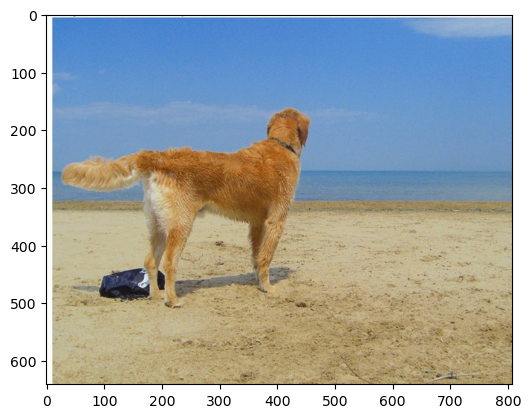

Example  1  OUTPUT: <SOS> a man in a red shirt is standing on a bench with a white dog . <EOS>


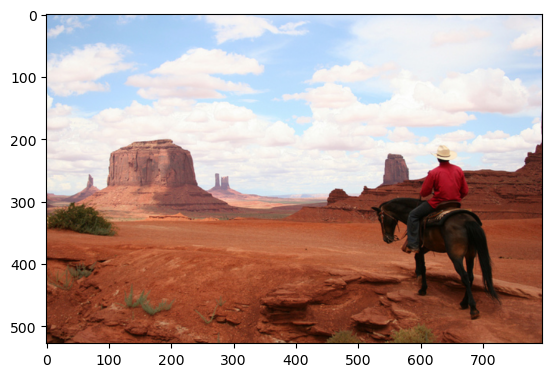

Example  2  OUTPUT: <SOS> a man in a red shirt is standing on a bench with a white dog . <EOS>


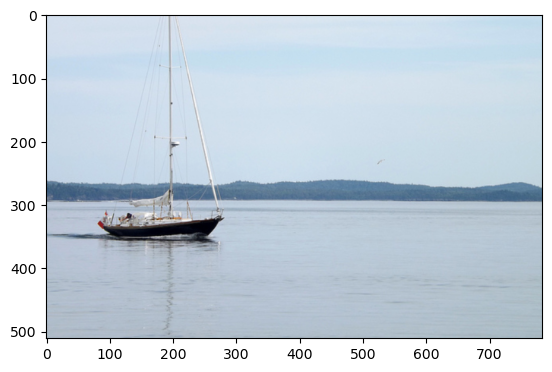

Example  3  OUTPUT: <SOS> a man in a red shirt is standing on a bench with a white dog . <EOS>


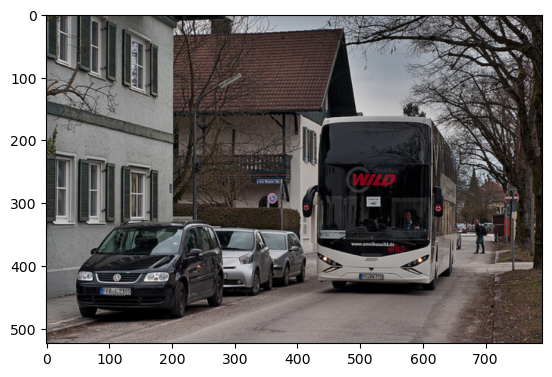

Example  5  OUTPUT: <SOS> a man in a red shirt is standing on a bench with a white dog . <EOS>


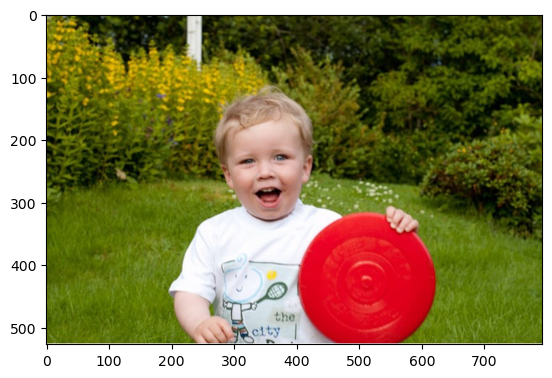

Example  6  OUTPUT: <SOS> a man in a red shirt is standing on a bench with a white dog . <EOS>


In [306]:
import matplotlib.pyplot as plt
import os

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

imageCaptioner.CNNtoRNN.eval()

directory = "test_examples"

for i, filename in enumerate(os.scandir(directory)):
    if filename.is_file():
        if (filename.path.endswith(".jpg") or filename.path.endswith(".png")):
            test_img = transform(Image.open(filename.path).convert("RGB")).unsqueeze(0)
            plt.imshow(Image.open(filename.path).convert("RGB"))
            plt.show()
            print("Example ", i+1, " OUTPUT: " + " ".join(imageCaptioner.CNNtoRNN.caption_image(test_img, dataset.vocab)))


Possible tutorials:

https://www.youtube.com/watch?v=y2BaTt1fxJU <- Used this one very nice

https://www.youtube.com/watch?v=9sHcLvVXsns And this to create the data loader

https://medium.com/@deepeshrishu09/automatic-image-captioning-with-pytorch-cf576c98d319

https://github.com/reppertj/image-captioning

https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Image-Captioning

